# JustStayStill - A Rocket League Bot

Goal: 
Teach a (relatively) simple Machine Learning Model to fly in Rocket League and stay still while doing it.

## Setup and Installation of packages

#### Creation of a python environment (optional)
```bash
pyenv install 3.11.12
~/.pyenv/versions/3.11.12/bin/python -m venv .venv_juststaystill
```

On Linux / Mac:
```bash
source ./.venv_juststaystill/bin/activate
```
On Windows:
```bash
.\.venv_juststaystill\bin\Activate.ps1
```

#### Install the required packages
```bash

pip install -r requirements.txt
```
> Note: This Code was tested on python 3.11.12 - other versions might work

In [1]:
# %% setup and imports
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

from stable_baselines3.common.monitor import Monitor

import os
import numpy as np

# output from this cell is to be ignored as it showing some warnings from stable_baselines3 / cuda


2025-07-28 23:37:16.458451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753738636.469128   22834 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753738636.472560   22834 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753738636.481876   22834 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753738636.481885   22834 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753738636.481886   22834 computation_placer.cc:177] computation placer alr

In [6]:
# %% settings
NR_STEPS = 5e5  # 5e5 = 500k - for full training this is used
VERBOSITY_IN_TRAINING = 0 # values above 0 will print something to STDOUT in execution
VERBOSITY_OF_ENV = 1
VERBOSITY_IN_CALLBACK = 0  # 0 prints nothing, anything about will print when a model is saved
CALLBACK_FREQUENCY = 1000  # every Nth step the callback is called
LOG_DIR = "/tmp/gym/"

# also prepare logging directory
os.makedirs(LOG_DIR, exist_ok=True)

In [3]:
# define custom monitored environment
# # custom environment for rocket league simulation
from rocket_sim_env import RocketSimFlyingEnv
def make_monitored_env():
    env = RocketSimFlyingEnv(verbosity=VERBOSITY_OF_ENV, log_csv_file="ppo_3e4_rocket_sim_flying_env_log.csv")
    env = Monitor(env, LOG_DIR)
    return env

In [4]:
# %% instanciation 
# import custom callbacks
from sb3_callbacks import SaveOnBestTrainingRewardCallback, CsvLoggerCallback

env = make_vec_env(make_monitored_env, n_envs=1)
best_model_callback = SaveOnBestTrainingRewardCallback(check_freq=CALLBACK_FREQUENCY, log_dir=LOG_DIR, verbose=VERBOSITY_IN_CALLBACK, do_saves=True)
#csv_logger = CsvLoggerCallback(log_dir=LOG_DIR, verbose=VERBOSITY_IN_CALLBACK)

model = PPO("MlpPolicy", env, n_steps=256,verbose=VERBOSITY_IN_TRAINING)


In [5]:
model.learn(total_timesteps=NR_STEPS, callback=best_model_callback)
model.save(f"modelsaves/sb3_rocket_sim_ppo_after_{NR_STEPS}steps")

In [6]:
#from training_utils import sb3_plot_results

#sb3_plot_results(LOG_DIR, title="RocketSim PPO")

# note: some of these plots are not very useful and show essentially nonsensical values

## Custom Model 

This section contains code for a custom keras-based RNN model that will be trained on the same environment as the stable baselines

> Reference to the accompanying report for a discussion about results

In [2]:

from keras_callbacks import SaveBestModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

from collections import deque
import random
import os
import numpy as np


2025-07-29 08:48:59.325550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753771739.336023   22934 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753771739.339155   22934 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753771739.348252   22934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753771739.348260   22934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753771739.348261   22934 computation_placer.cc:177] computation placer alr

In [3]:
def build_rnn_model(seq_length=10, obs_dim=44, action_dim=8):
    input_layer = Input(shape=(seq_length, obs_dim), name='observation_sequence')
    x = LSTM(128, return_sequences=False)(input_layer)
    x = Dense(64, activation='relu')(x)
    output = Dense(action_dim, activation='tanh')(x)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model


class ReplayBuffer:
    def __init__(self, capacity=10000, seq_length=10):
        self.buffer = deque(maxlen=capacity)
        self.seq_length = seq_length

    def add(self, trajectory):
        self.buffer.append(trajectory)

    def sample(self, batch_size=32):
        batch = random.sample(self.buffer, batch_size)
        obs_seqs, actions, rewards, next_obs_seqs, dones = zip(*batch)
        return np.array(obs_seqs), np.array(actions), np.array(rewards), np.array(next_obs_seqs), np.array(dones)




In [4]:
import numpy as np

# %% training function / loop
def train_rnn_agent(env, model, total_steps, seq_length=10, gamma=0.99,
                    buffer_size=1000, batch_size=32, eval_every=1000, verbosity=0, log_dir="./logs"):
    os.makedirs(log_dir, exist_ok=True)
    buffer = ReplayBuffer(capacity=buffer_size, seq_length=seq_length)
    
    saver = SaveBestModel(os.path.join(log_dir, "best_model.keras"))
    
    # Early stopping parameters
    runs = 0
    early_stop_window = 5  # Number of episodes to average over
    early_stop_threshold = 0.10  # 10% change
    steps = 0
    running_rewards = []  # Store total_reward for calculations
    while steps < total_steps:
        
        obs_buffer = deque(maxlen=seq_length)
        obs, _ = env.reset()
        done = False
        total_reward = 0
        
        
        for _ in range(seq_length):
            obs_buffer.append(np.zeros_like(obs))
        obs_buffer.append(obs)
        
        while not done:
            
            obs_seq = np.array(obs_buffer).reshape((1, seq_length, -1))
            action = model.predict(obs_seq, verbose=0)[0]
            next_obs, reward, done, _, _ = env.step(action)
            obs_buffer.append(next_obs)
            next_obs_seq = np.array(obs_buffer).reshape((seq_length, -1))
            buffer.add((obs_seq.squeeze(), action, reward, next_obs_seq, done))
            steps += 1
            if len(buffer.buffer) >= batch_size:
                obs_seqs, actions, rewards, next_obs_seqs, dones = buffer.sample(batch_size)
                target_actions = model.predict(next_obs_seqs, verbose=0)
                targets = actions + gamma * target_actions * (1 - np.array(dones)[:, None])
                model.train_on_batch(obs_seqs, targets)
            total_reward += reward
                 
        runs += 1
        
        running_rewards.append(total_reward)
        if len(running_rewards) >= early_stop_window:
            # Calculate average change in recent rewards
            changes = np.diff(running_rewards[-early_stop_window:])
            avg_change = np.mean(np.abs(changes))
            if avg_change < early_stop_threshold:
                if verbosity > 0:
                    print(f"Early stopping at run {runs} with average change in reward {avg_change:.4f} (threshold: {early_stop_threshold})")
                break
        
        
        avg_reward = np.mean(running_rewards[-100:]) if len(running_rewards) >= 1 else total_reward
        if verbosity > 0:
            print(f"Step: {steps}, Total Reward: {total_reward}, Avg Reward: {avg_reward:.2f}")
            

In [10]:
# %% instantiate environment and model
from rocket_sim_env import RocketSimFlyingEnv   # if you want to run this code, instead of the whole notebook
env = RocketSimFlyingEnv(verbosity=VERBOSITY_OF_ENV, log_csv_file="keras_500ep_rocket_sim_flying_env_log.csv")  # your custom environment
model = build_rnn_model()

# %% train the RNN agent
train_rnn_agent(env, model, 50000)
model.save("modelsaves/keras_rocket_sim_rnn_after_50000steps.keras")

2025-07-29 00:43:09.750315: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Run finished | Steps: 1205 | Reward: 0.00 | Running Avg (last 100): 0.00ocity: 2300.00 | Reward: 0.00 | Done: True | Is Flying: Falseeeee
Run finished | Steps: 2410 | Reward: 0.00 | Running Avg (last 100): 0.00city: 2300.00 | Reward: 0.00 | Done: True | Is Flying: Falseeeee
Run finished | Steps: 3615 | Reward: 0.00 | Running Avg (last 100): 0.00city: 2300.00 | Reward: 0.00 | Done: True | Is Flying: Falseeeee
Run finished | Steps: 4820 | Reward: 0.00 | Running Avg (last 100): 0.00city: 2300.00 | Reward: 0.00 | Done: True | Is Flying: Falseeeee
Run finished | Steps: 6025 | Reward: 0.00 | Running Avg (last 100): 0.00city: 2300.00 | Reward: 0.00 | Done: True | Is Flying: Falseeeee
Run finished | Steps: 7230 | Reward: 0.00 | Running Avg (last 100): 0.00city: 2300.00 | Reward: 0.00 | Done: True | Is Flying: Falseeeee
Run finished | Steps: 8435 | Reward: 0.00 | Running Avg (last 100): 0.00city: 2300.00 | Reward: 0.00 | Done: True | Is Flying: Falseeeee
Run finished | Steps: 9640 | Reward: 0.0

In [ ]:
# read in the data from the keras and ppo training run csv files
# plot all the data in respect to the timesteps
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from PIL import Image

ppo_csv = pd.read_csv("ppo_3e4_rocket_sim_flying_env_log.csv")
keras_csv = pd.read_csv("keras_500ep_rocket_sim_flying_env_log.csv")

available_columns = ['step', 'total_steps', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'velocity',
       'reward', 'done', 'is_flying']

columns_to_plot = ['reward', 'velocity']

def assign_run_numbers(csv_data):
    steps = csv_data['step'].values
    run_numbers = np.zeros(len(steps), dtype=int)
    run_id = 0
    run_numbers[0] = run_id
    for i in range(1, len(steps)):
        if steps[i] < steps[i-1]:
            run_id += 1
        run_numbers[i] = run_id
    csv_data = csv_data.copy()
    csv_data['run_number'] = run_numbers
    return csv_data

ppo_csv = assign_run_numbers(ppo_csv)
keras_csv = assign_run_numbers(keras_csv)

def plot_avg_metric_per_run(csv_data, metric, filename=None, title=None, return_pil=False):
    grouped = csv_data.groupby('run_number')[metric].mean()
    plt.figure(figsize=(10, 5))
    plt.plot(grouped.index, grouped.values, marker='o', label=f'Average {metric}')
    # Trend-line (linear regression)
    if len(grouped.index) > 1:
        coeffs = np.polyfit(grouped.index, grouped.values, 1)
        trend = np.polyval(coeffs, grouped.index)
        plt.plot(grouped.index, trend, color='red', linestyle='--', label='Trend-line')
    plt.xlabel('Run Number')
    plt.ylabel(f'Average {metric}')
    plt.title(title or f'Average {metric} per Run')
    plt.grid()
    plt.legend()
    if return_pil:
        buf = BytesIO()
        
        plt.savefig(buf, format='png', bbox_inches='tight')
        plt.close()
        buf.seek(0)
        img = Image.open(buf)
        return img
    else:
        if filename:
            plt.savefig(filename, format='png', bbox_inches='tight')
        plt.close()
        return None
    

# Plot average reward and velocity per run for PPO
plot_avg_metric_per_run(ppo_csv, 'reward', 'imgs/ppo_avg_reward_per_run.png', 'PPO: Average Reward per Run')
plot_avg_metric_per_run(ppo_csv, 'velocity', 'imgs/ppo_avg_velocity_per_run.png', 'PPO: Average Velocity per Run')

# Plot average reward and velocity per run for Keras
plot_avg_metric_per_run(keras_csv, 'reward', 'imgs/keras_avg_reward_per_run.png', 'Keras: Average Reward per Run')
plot_avg_metric_per_run(keras_csv, 'velocity', 'imgs/keras_avg_velocity_per_run.png', 'Keras: Average Velocity per Run')


### PPO Model Metric Visualizations

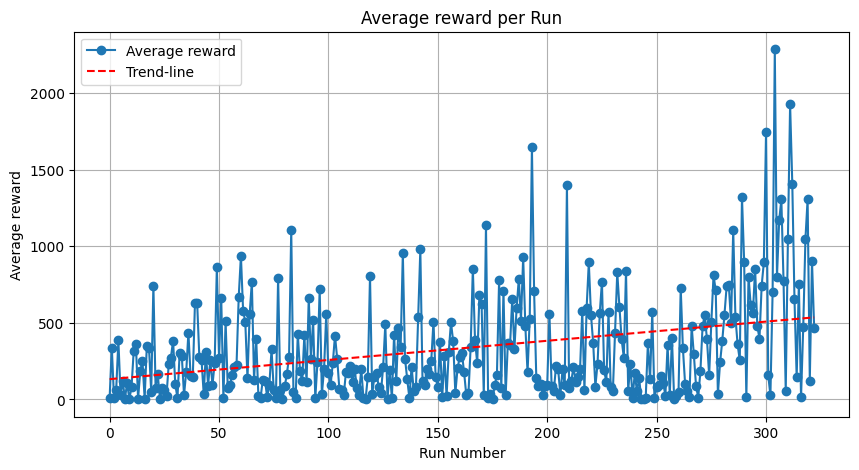

In [62]:
avg_reward = plot_avg_metric_per_run(ppo_csv, 'reward', 'PPO: Average Reward per Run', return_pil=True)
avg_reward

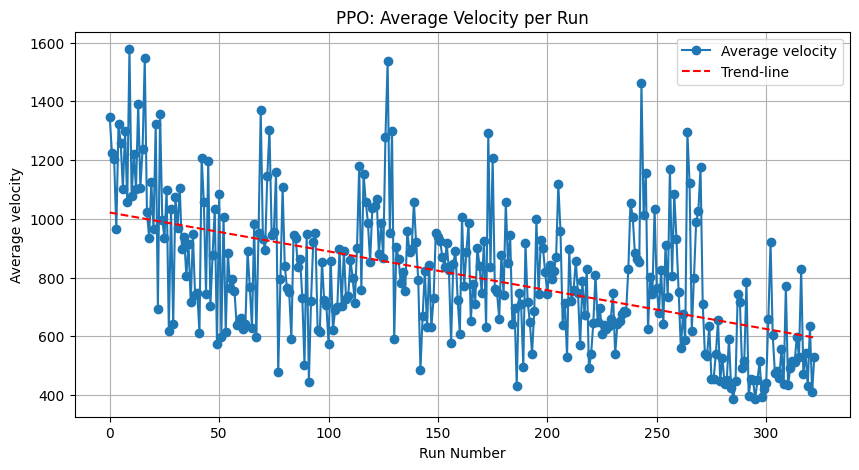

In [63]:
avg_velocity = plot_avg_metric_per_run(ppo_csv, 'velocity', 'ppo_avg_velocity_per_run.png', 'PPO: Average Velocity per Run', return_pil=True)
avg_velocity

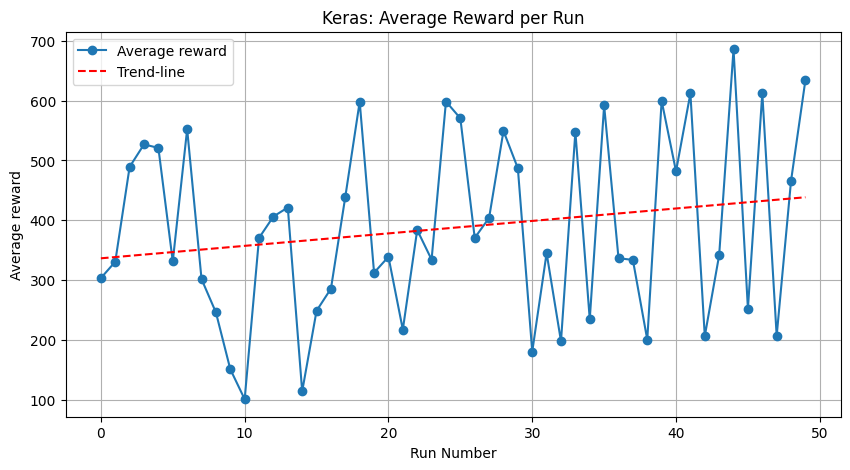

In [64]:
avg_reward = plot_avg_metric_per_run(keras_csv, 'reward', 'keras_avg_reward_per_run.png', 'Keras: Average Reward per Run', return_pil=True)
avg_reward

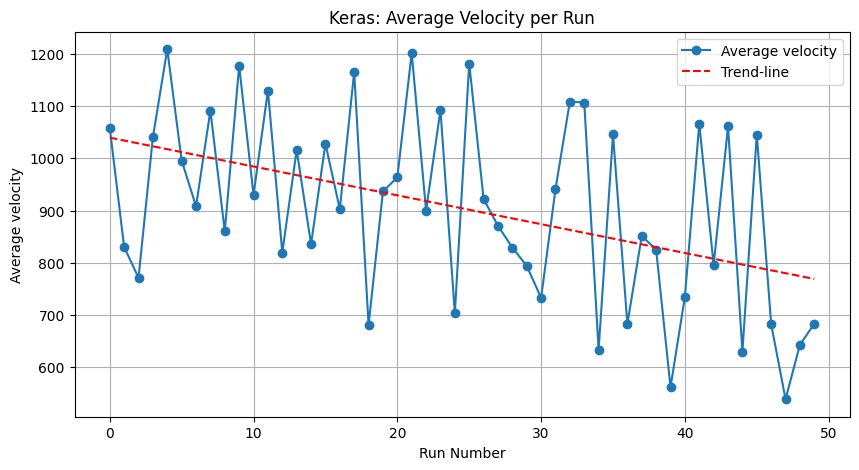

In [65]:
avg_velocity = plot_avg_metric_per_run(keras_csv, 'velocity', 'keras_avg_velocity_per_run.png', 'Keras: Average Velocity per Run', return_pil=True)
avg_velocity